# TKT4196 - Aspects of Structural Safety
## CE1 - Suggested solution to the first Compulsory exercise

Functions that will later be used are written in a separate file named `P1_functions.py`

Importing packages and general settings: 

In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from P1_functions import plots_task3,optdesign,plots_task4
from matplotlib.figure import figaspect
fontsizes=18
plt.rcParams.update({'font.size': fontsizes})
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"mathtext.fontset" : "cm"})
plt.rcParams.update({'font.serif': 'Times New Roman'})
plt.close('all')

### Method of solving in Python
In the solutions in this course we generally use functions instead of arrays for finding optima. Arrays are generally only used for plotting or simulation. This allows us to use numerical solvers as `fsolve` (finds a root of a function) or `scipy.optimize.minimize` (finds local minimum). The perk of this that the we can define the accuracy we want directly when applying the solver. This generally saves computing time. If we want an accurate solution using arrays we might need very large arrays. This is of course generally not needed when plotting, for example.

To define a function $f(x) = 2x + 1$, recall that you can do one of the following.

`def f(x):
    return 2*x + 1
`

or

`def f(x): return 2*x + 1
`

or, the method we often use

`f = lambda x: 2*x + 1`

For plotting, you can then generate an array of function values by applying the function to an array of x-values.

`x_arr = np.linspace(0,10,100)
f_arr = f(x_arr)
plt.plot(x_arr, f_arr)`

or, even shorter

`x_arr = np.linspace(0,10,100)
plt.plot(x_arr, f(x_arr))`

Note that if your functions contains `if`-statements you might need to vectorize the function to allow applying it to an array. This is done the following way:

`plt.plot(x_arr, np.vectorize(f)(x_arr))`

Defining variables to be used in the exercise. Most of these variables are given directly in table 1 in the Compulsory exercise: 

In [3]:
# Input
m_top = 3e5;             # RNA kg 
mu_E = 210e9;            # Young modulus
sigma_E = mu_E*0.03      # Young modulus
mu_rho = 8500;           # Density of steel [kg/m3]
sigma_rho = mu_rho*0.05; # Density of steel [kg/m3]
min_rs = 5.1/60;         # minimum rotor speed [Hz]
max_rs = 13.8/60;        # maximum rotor speed [Hz] 
d_tower = 4.2            # outer diameter of tower [m]
H_tower = 72             # Height of tower
H_mono =  23             # Height of monopile above mudline
H_penetr = 10            # Penetration depth of the moonopile
H_hub = 80               # Hub height
d_eff = lambda d: 3.5*d  # Effective fixity depth
H = lambda d: H_tower + H_mono + d_eff(d)   # Total height of monolithic model

## Task 1

You are asked to estimate the expected first natural frequency of the structure and plot it as a function
of the monopile diameter. Show in the plot which range of values satisfy Eq. (1).

First we generate a set of design candidates and their associated cross-section area and inertia: 

In [4]:
# Building design sets
diameters = np.linspace(4.5,5.5, num=100)      # set of considered diameters
t_w = lambda d: d/100                          # thickness
I = lambda d: np.pi/64*(d**4-(d-2*t_w(d))**4)  # area moment of inertia
A = lambda d: np.pi/4*(d**2-(d-2*t_w(d))**2)   # cross-section area

Second, we build the monolothic model as a function of the design parameter. Since $l_1$, $l_2$, $x_1$ and $x_2$ are used in multiple calculations it is good coding practice to make a function for them, and calling this when needed in calculations. If we find mistakes in the function this method only requires us to fix the code in one place.

In [5]:
#Calculating the height
def monolithic(d):
    l1 = H_tower
    x1 = H(d)-H_tower/2
    l2 = H(d)-H_tower
    x2 = l2/2
    return l1,x1,l2,x2

Now we are ready to compute the equivalent mass and inertia as a function of the design parameter:

In [6]:
# Creating a function to calculate the equivalent moment of inertia, which is dependent on d
def Ieq(d):
    """Calculates equivalent intertia as a function of the diameter of the monopile"""
    l1,x1,l2,x2 = monolithic(d)
    I1 = I(4.2)*l1*np.cos(np.pi/2 * x1/H(d))**2
    I2 = I(d)*l2*np.cos(np.pi/2 * x2/H(d))**2
    return (I1+I2)/H(d)


In [7]:
# Creating a function to calculate the equivalent mass, which is dependent on d
def meq(rho,d):
    """Calculates equivalent mass as a function of the diameter of the monopile"""
    l1,x1,l2,x2 = monolithic(d)
    m1 = rho*A(4.2)*l1*(1-np.cos(np.pi/2 * x1/H(d)))**2
    m2 = rho*A(d)*l2*(1-np.cos(np.pi/2 * x2/H(d)))**2
    return (m1+m2)/H(d)

Now we write the functional relationship between the input and the first natural frequency: 

In [8]:
Fn = lambda d,rho,e: np.pi/8*np.sqrt(e*Ieq(d)/((m_top+meq(rho,d)*H(d))*H(d)**3))

We compute the expected first natural frequency from the mean value of the random variables, as an approximation. This approximation is valid because the standard deviations of the normal distributed variables are small. Alternatively, Monte Carlo simulations can be used for this purpose. This is not crucial since we do not use the estimate of the expected natural frequency for further calculations.

In [9]:
# Mean first natural frequency
mu_Fn = lambda d: Fn(d,mu_rho,mu_E)

The next paragraph is used when plotting the dotted line of the 95% confidence interval. This is not asked for in the exercise and it's just shown for illustration purposes. 

In [10]:
# Estimation of standard deviation of first natural frequency
n_sim = int(1e5)
e_rand = np.random.normal(loc=mu_E, scale=sigma_E, size=n_sim)
rho_rand = np.random.normal(loc=mu_rho, scale=sigma_rho, size=n_sim)
fn_rand = lambda d: Fn(d,rho_rand,e_rand)
sigma_fn = np.empty(diameters.size)
mu_fn_rnd = np.empty(diameters.size)
for i in range(len(diameters)):
    mu_fn_rnd[i] = np.mean(fn_rand(diameters[i]))
    sigma_fn[i] = np.std(fn_rand(diameters[i]))

prob = np.arange(1,n_sim+1)/(n_sim+1)
counts, bins = np.histogram(fn_rand(5))
fn_rand5 = np.sort(fn_rand(5))
fn_bound1 = (fn_rand5[np.where(prob<0.025)[0][-1]]-mu_Fn(5))/-np.std(fn_rand(5))
fn_bound2 = (fn_rand5[np.where(prob<0.975)[0][-1]]-mu_Fn(5))/np.std(fn_rand(5))

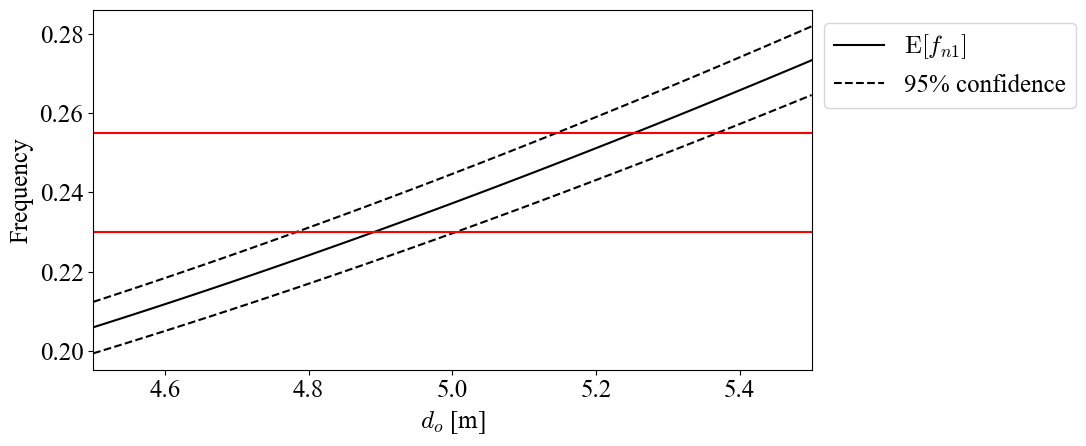

In [11]:
# Solution Task 1
wp, hp = figaspect(3/7)
fig, ax = plt.subplots(figsize=(wp,hp))
ax.plot(diameters,mu_Fn(diameters),'k',label='$\mathrm{E}[f_{n1}]$')
ax.plot(diameters,mu_Fn(diameters)-fn_bound1*sigma_fn,'--k',label='95% confidence')
ax.plot(diameters,mu_Fn(diameters)+fn_bound2*sigma_fn,'--k')
ax.plot([diameters[0],diameters[-1]],np.array([1,1])*min_rs*3,'r')
ax.plot([diameters[0],diameters[-1]],np.array([1,1])*max_rs,'r')
ax.set_xlabel('$d_{o}$ [m]')
ax.set_xlim(diameters[0],diameters[-1])
ax.set_ylabel('Frequency')
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Task 2

Express the two inequations in Eq. (1) as two limit state functions $g_{P1}$ and $g_{P3}$ that
are linear with respect to the random variables of the problem, i.e. $E$ and $\rho_s$.

The resistance and load variables of the limit state are written *generically* first. This function will be evaluated accordingly for the two limit states later on.

In [12]:
def lsf_generic(R_list,S_list):
    beta = (R_list[0]-S_list[0])/np.sqrt(R_list[1]**2+S_list[1]**2)
    pf = sp.stats.norm.cdf(-beta)
    return beta,pf

In [13]:
def lsf_generic_variables(d,omega):
    X1 = lambda e: e*Ieq(d)
    X2_mu = (omega*8/np.pi)**2 * (m_top+meq(mu_rho,d)*H(d))*H(d)**3
    X2_sigma = (omega*8/np.pi)**2 * meq(sigma_rho,d)*H(d)**4
    X1_list = [X1(mu_E),X1(sigma_E)]
    X2_list = [X2_mu,X2_sigma]
    return X1_list, X2_list 


Now we assign the resistance and load variables and the rotational speed limit accordingly:

In [14]:
def lsf_left(d):
    """Calculation of reliability index and prob. of failure 
    of left limit state function as a function of diameter
    
    beta, pf = lsf_left(d)"""
    X1_list, X2_list = lsf_generic_variables(d,max_rs)
    R = X1_list
    S = X2_list
    beta,pf = lsf_generic(R,S)
    
    return beta, pf

In [15]:
def lsf_right(d):
    """Calculation of reliability index and prob. of failure 
    of right limit state function as a function of diameter
    
    beta, pf = lsf_right(d)"""
    X1_list, X2_list = lsf_generic_variables(d,min_rs*3)
    R = X2_list
    S = X1_list
    beta,pf = lsf_generic(R,S)
    
    return beta, pf

## Task 3

Estimate the reliability index and the probability of failure associated with each limit
state and plot them as a function of the decision parameter, i.e. the monopile diameter
do. Moreover, calculate the probability of failure of the union of both limit states, i.e.
$P_f = P_r((g_{P1} ≤ 0) ∪ (g_{P3} ≤ 0))$.

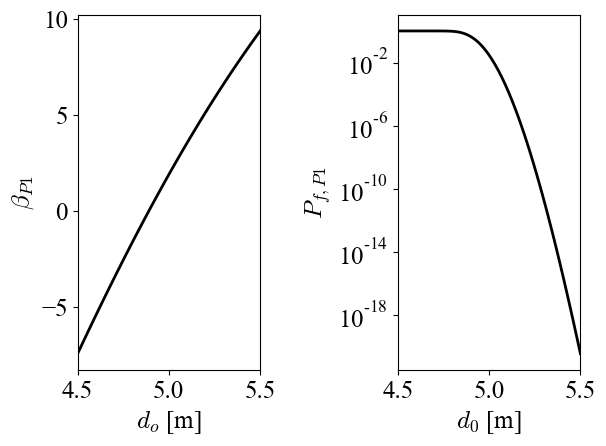

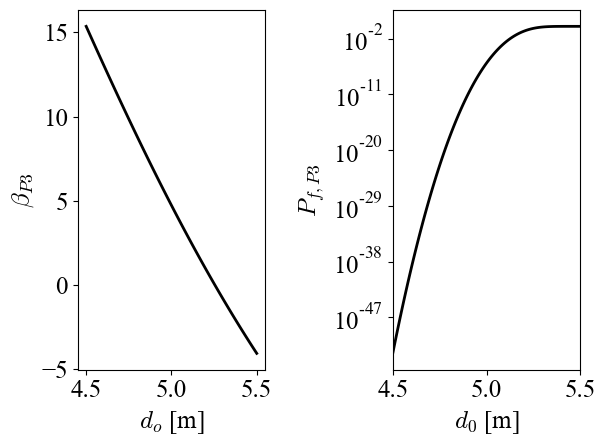

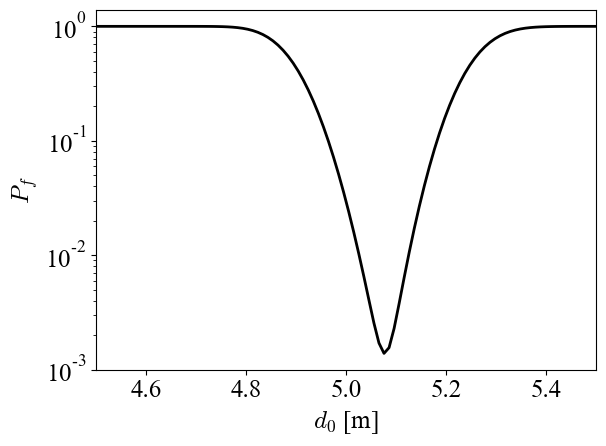

 final_simplex: (array([[5.07739258],
       [5.07745361]]), array([0.00138288, 0.00138288]))
           fun: 0.0013828754176654604
       message: 'Optimization terminated successfully.'
          nfev: 26
           nit: 13
        status: 0
       success: True
             x: array([5.07739258])

Minimum probability of failure: 1.383e-03


In [24]:
beta_left, pf_left = lsf_left(diameters)
beta_right, pf_right = lsf_right(diameters)

Pf = lambda d: lsf_left(d)[1]+lsf_right(d)[1]
# We have coded the plots in the separate file
plots_task3(diameters,beta_left,pf_left,beta_right,pf_right)
#The numerical solver needs a starting point. We see from task 1 that the diameter will be around 5 meters.
d_guess = 5 #[m]
res = sp.optimize.minimize(Pf,x0=d_guess,method='Nelder-Mead')
print(res)
print('\nMinimum probability of failure: %.3e' % Pf(res.x))

## Task 4

Compute the finite life expected cost of the structure and plot it as a function of the
monopile diameter. Find the optimal diameter that minimizes this cost.

First, we write the cost model:

In [17]:
# Cost model

C0 = 10000000                                                             # [NOK] Fixed cost of construction
C1 = lambda d: 5 * mu_rho * (A(d_tower)*H_tower+A(d)*(H_mono+H_penetr))   # [NOK/mm] Variable cost
i = 0.03                                                                  # interest rate
TSL = 25                                                                  # Service life
# Not discounted costs
C_c = lambda d: C0 + C1(d)                                                # Construction cost
EC_f = lambda d: (C_c(d)*5)* Pf(d) * 1/(1+i)**TSL                         # Expected failure cost
ECtot = lambda d: C_c(d) + EC_f(d)                                        # Objective function

We compute now the optimal diameter by numerical minimization of the expected total cost:

In [20]:
# Compute optimum
d_opt,pf_opt,beta_opt,ECtot_min = optdesign(ECtot,Pf)

s1  = "Optimum diameter: {d:.3f} m\nOptimum thickness: {t:.3f} m\n".format(d=d_opt,t=t_w(d_opt))
s2 = "Optimum probability of failure: {pf:.2e}\nOptimum beta: {b:.2f}\n".format(pf=pf_opt,b = beta_opt)
s3 = "Minimum expected total cost = {c:.0f} NOK\n".format(c = ECtot_min)
print(s1+s2+s3)

Optimization terminated successfully.
         Current function value: 12844955.707979
         Iterations: 29
         Function evaluations: 59
Optimum diameter: 5.074 m
Optimum thickness: 0.051 m
Optimum probability of failure: 1.41e-03
Optimum beta: 2.99
Minimum expected total cost = 12844956 NOK



Finally, we plot the results:

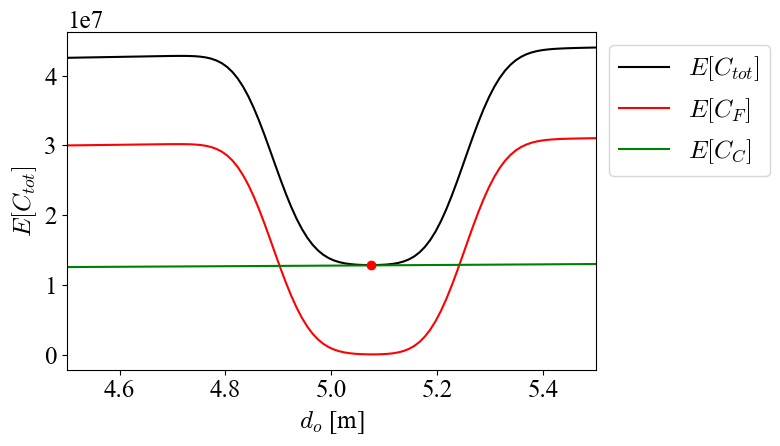

In [21]:
ax = plots_task4(diameters,ECtot,EC_f,C_c)
ax.plot(d_opt,ECtot(d_opt),'or')
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()